# Experiment-training|NPB_lu

### Import library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore')

### Data alignment

In [3]:
# calculting the fitting value R2
from sklearn.metrics import r2_score
def caculateMse_R2(x,y,p):
    y_pre = [p(i) for i in x]
    score = r2_score(y, y_pre, multioutput='raw_values')
    return score[0]

# merge list，[[x1,y1],[x2,y2],...,[xn,yn]]

def list_set(x,y):
    list=[]
    for i in range(0,len(x)):
        list.append([x[i],y[i]])
    return list

# Extend the short series

def data_set_fix(list,x):
    n=0;
    data=0;
    for i in range(0,len(list)):
        if n==0:
            if list[i][0]==x:
                n=1
                data=list[i][1]
        else:
            list[i][1]=data
    
    return list


In [4]:
# Single series data alignment method
def align_data_singe(x,y,x1,n):
    
    # fitting,if R2<0.9 do re-fitting
    while True:
        coef = np.polyfit(x,y, n)
        poly_fit = np.poly1d(coef)
        R2 = caculateMse_R2(x,y,poly_fit)
        if n>=19:
            break
        if R2>0.9:
            break
        else:
            n=n+1 
        
    # list
    data_set = list_set(x,y)
    
    # Data alignment
    for i in range(0,len(x1)):
         data_set.append([x1[i],poly_fit(x1[i])])
    
    # sort
    data_set.sort();
    
    return data_set
    
# double seriers alignment
def align_data(x1,y1,x2,y2):
    timeseries1 = align_data_singe(x1,y1,x2,6)
    timeseries2 = align_data_singe(x2,y2,x1,6)
    
   # data fitting（short series align to the long series，tail data mean as the current value）
    if(len(x1)>len(x2)):
        timeseries2 = data_set_fix(timeseries2,x2[-1])
    else:
        timeseries1 = data_set_fix(timeseries1,x1[-1])
    
    return timeseries1,timeseries2

### Sequence attribute and feature evaluation algorithm

In [5]:
# DTW distance
# calculating the weight
def calculate_attenuate_weight(seqLen1, seqLen2, com_ls):
    weight = 0
    for comlen in com_ls:
        weight = weight + comlen / seqLen1 * comlen / seqLen2
    return 1 - weight

# DTW distance
def DTWDistance(s1, s2):
    # acquire std
    sdt = np.std(s1, ddof=1) if np.std(s1, ddof=1) > np.std(s2, ddof=1) else np.std(s2, ddof=1)
    l1 = len(s1)
    l2 = len(s2)
    paths = np.full((l1 + 1, l2 + 1), np.inf)  # assign infinity
    sub_matrix = np.full((l1, l2), 0)  # assign 0
    max_sub_len = 0

    paths[0, 0] = 0
    for i in range(l1):
        for j in range(l2):
            d = s1[i] - s2[j]
            cost = d ** 2
            paths[i + 1, j + 1] = cost + min(paths[i, j + 1], paths[i + 1, j], paths[i, j])
            if np.abs(s1[i] - s2[j]) < sdt:
                if i == 0 or j == 0:
                    sub_matrix[i][j] = 1
                else:
                    sub_matrix[i][j] = sub_matrix[i - 1][j - 1] + 1
                    max_sub_len = sub_matrix[i][j] if sub_matrix[i][j] > max_sub_len else max_sub_len

    paths = np.sqrt(paths)
    s = paths[l1, l2]

    return s

In [6]:
#LB_Keogh
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return math.sqrt(LB_sum)

In [7]:
# Similarity
def Dtw_LB_conter(data1,data2,r):
    l=LB_Keogh(data1,data2,r)+DTWDistance(data1,data2)
    return l/2

def getMin(a,b):
    if a<b:
        return a
    else:
        return b

In [8]:
def timeseries_score(s1,s2,w,r):
    # series:s1，series:s2, w:sliding window size,r:slope sliding window   
    # time ratio
    time_s1_s2 = s2[0][len(s2[0])-1]/s1[0][len(s1[0])-1]
    
       # time ratio via sliding window 
    time_sum=0;
    for i in range(math.ceil(len(s1[0])/w)):
        s1_time = sum(s1[0][i:i+w])
        s2_time = sum(s2[0][i:i+w])
        i=i+w
        time_sum =time_sum + s2_time/s1_time    

    time_sum = time_sum/math.ceil(len(s1[0])/w)
    
        # Mean ratio
    heartbeat_s1 = (sum(s1[1])/len(s1[1]))
    heartbeat_s1_s2 = sum(s2[1])/len(s2[1])/(sum(s1[1])/len(s1[1]))
    
    # Mean ratio via sliding window 
    heartbeat_sum=0;
    for i in range(math.ceil(len(s1[1])/w)):
        s1_heartbeat = sum(s1[1][i:i+w])
        s2_heartbeat = sum(s2[1][i:i+w])
        i=i+w
        heartbeat_sum =heartbeat_sum + s2_heartbeat/s1_heartbeat    

    heartbeat_sum = heartbeat_sum/math.ceil(len(s1[1])/w)
    
    # slope ratio via sliding window
    slope_sum=0;
    for i in range(math.ceil(getMin(len(s1[1])/r,len(s2[1])/r))):
        
        k=i+r
        if(k>len(s1[1])):
            k=len(s1[1])  
        
        s1_slope = (s1[1][i]-s1[1][k])/(s1[0][i]-s1[0][k])
        s2_slope = (s2[1][i]-s2[1][k])/(s2[0][i]-s2[0][k])
        
        i=i+r
        slope_sum =slope_sum + abs(s2_slope/s1_slope)    

    slope_sum = slope_sum/math.ceil(math.ceil(len(s1[1])/r))

    return [time_s1_s2,time_sum,heartbeat_s1,heartbeat_s1_s2,heartbeat_sum,slope_sum]

In [9]:
def similar_all(x1,y1,x2,y2,tS1,tS2):
    x_p1 =[ tS1[i][0] for i in range(0,len(tS1))]
    y_p1 =[ tS1[i][1] for i in range(0,len(tS1))]
    x_p2 =[ tS2[i][0] for i in range(0,len(tS2))]
    y_p2 =[ tS2[i][1] for i in range(0,len(tS2))]
    
    feature = timeseries_score([x1,y1],[x2,y2],200,20)
    distent = Dtw_LB_conter(y_p1,y_p2,100)
    
    return feature,distent

### Experiments - parameter setting

#### import data

In [13]:
#import data
import pandas as pd
data = pd.read_excel('./normal_lu_1.xlsx',sheet_name=None)
print(len(data))

1


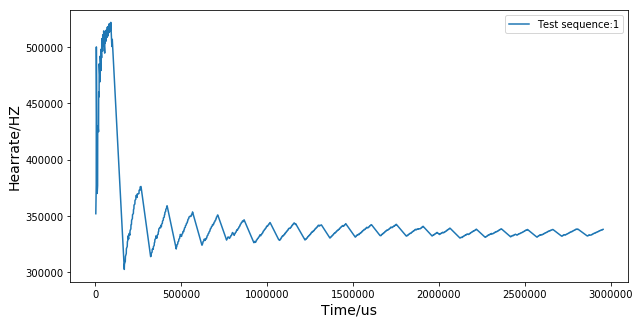

In [14]:
plt.figure(figsize=(10,5))
data = pd.read_excel('./normal_lu_1.xlsx',hearder=None,sheet_name=None)
k=1 
for i in data: 
    x6 = data[i]['time'].copy()[0:999]
    y6 = data[i]['heartrate'].copy()[0:999]
    label_name = 'Test sequence:'+str(k)
    plt.plot(x6,y6,label=label_name)
    k = k+1
plt.xlabel('Time/us',fontsize=14)
plt.ylabel('Hearrate/HZ',fontsize=14)
plt.legend(loc=0,ncol=3,borderaxespad=0.5)   
plt.show()

In [15]:
def lab(x,y,ll):
    SeriesFeature=[]
    for j in data:
        title_times = "Processing:"+str(ll)+",round:"+str(j)
        print(title_times)
        x2 = data[j]['time'].copy()[0:999]
        y2 = data[j]['heartrate'].copy()[0:999]
        x2 = np.array(x2)
        y2 = np.array(y2)

        timeSeries1,timeSeries2 = align_data(x,y,x2,y2)

        feature = similar_all(x,y,x2,y2,timeSeries1,timeSeries2)

        SeriesFeature.append(feature)
           
    # max
    max_time=0;
    local_max_time=0;
    max_hb=0;
    local_max_hb=0;
    local_max_slope=0
    max_dtw_lb=0;

    # min
    min_time=2;
    local_min_time=2;
    min_hb=2;
    local_min_hb=2;
    local_min_slope=2
    min_dtw_lb=9999999999999;
    
    # acquire max-min
    for feature in SeriesFeature:
 
        max_time = max_time  if max_time>feature[0][0] else feature[0][0]
        local_max_time = local_max_time  if local_max_time>feature[0][1] else feature[0][1]
        max_hb = max_hb  if max_hb>feature[0][3] else feature[0][3]
        local_max_hb = local_max_hb  if local_max_hb>feature[0][4] else feature[0][4]
        local_max_slope = local_max_slope  if local_max_slope>feature[0][5] else feature[0][5]
        max_dtw_lb = max_dtw_lb  if max_dtw_lb>feature[1] else feature[1]


        min_time = min_time  if min_time<feature[0][0] else feature[0][0]
        local_min_time = local_min_time  if local_min_time<feature[0][1] else feature[0][1]
        min_hb = min_hb  if min_hb<feature[0][3] else feature[0][3]
        local_min_hb = local_min_hb  if local_min_hb<feature[0][4] else feature[0][4]
        local_min_slope = local_min_slope  if local_min_slope<feature[0][5] else feature[0][5]
        min_dtw_lb = min_dtw_lb  if min_dtw_lb<feature[1] else feature[1]
    
    max_result.append([max_time,local_max_time,max_hb,local_max_hb,local_max_slope,max_dtw_lb])
    min_result.append([min_time,local_min_time,min_hb,local_min_hb,local_min_slope,min_dtw_lb])
    print("------------------------------------",ll)
    print("max",[max_time,local_max_time,max_hb,local_max_hb,local_max_slope,max_dtw_lb])
    print("min",[min_time,local_min_time,min_hb,local_min_hb,local_min_slope,min_dtw_lb])
    print("------------------------------------")

In [16]:
for ll in data:
    x = data[ll]['time'].copy()[0:999]
    y = data[ll]['heartrate'].copy()[0:999]
    x = np.array(x)
    y = np.array(y)
    max_result=[]
    min_result=[]
    lab(x,y,ll)

Processing:1,round:1
------------------------------------ 1
max [1.0, 1.0, 1.0, 1.0, 1.0, 3092.9822155850416]
min [1.0, 1.0, 1.0, 1.0, 1.0, 3092.9822155850416]
------------------------------------


In [17]:
ma=[0,0,0,0,0,0]
mi=[2,2,2,2,2,9999999]

def getMax_min(max_result,min_result):
    
    for i in range(len(max_result)):
        
        _max = max_result[i]
        
        for _i in range(0,6):
            if(_max[_i]>ma[_i]):
                ma[_i]=_max[_i]
    
    for i in range(len(min_result)):
        _min = min_result[i]
        for _i in range(0,6):
            if(_min[_i]<mi[_i]):
                mi[_i]=_min[_i]

In [18]:
getMax_min(max_result,min_result)
print("max:",ma)
print("min:",mi)

max: [1.0, 1.0, 1.0, 1.0, 1.0, 3092.9822155850416]
min: [1.0, 1.0, 1.0, 1.0, 1.0, 3092.9822155850416]
